# Análisis exploratorio

Visualización de distribuciones, correlaciones y patrones temporales del dataset AI4I 2020.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid', palette='muted')
df = pd.read_csv(Path('../data/ai4i_clean.csv'), index_col=0)
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temp_diff,Torque_per_rpm,Tool_state
UDI,,,,,,,,,,,,,,,,
1.0,M14860,M,298.1,308.6,1551.0,42.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,0.027595,Nuevo
2.0,L47181,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,0.032884,Nuevo
3.0,L47182,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,0.032977,Nuevo
4.0,L47183,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,0.027565,Nuevo
5.0,L47184,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,0.028409,Nuevo


## Histogramas de variables numéricas

Distribuciones de temperatura, velocidad, torque y desgaste para ver asimetrías y colas.

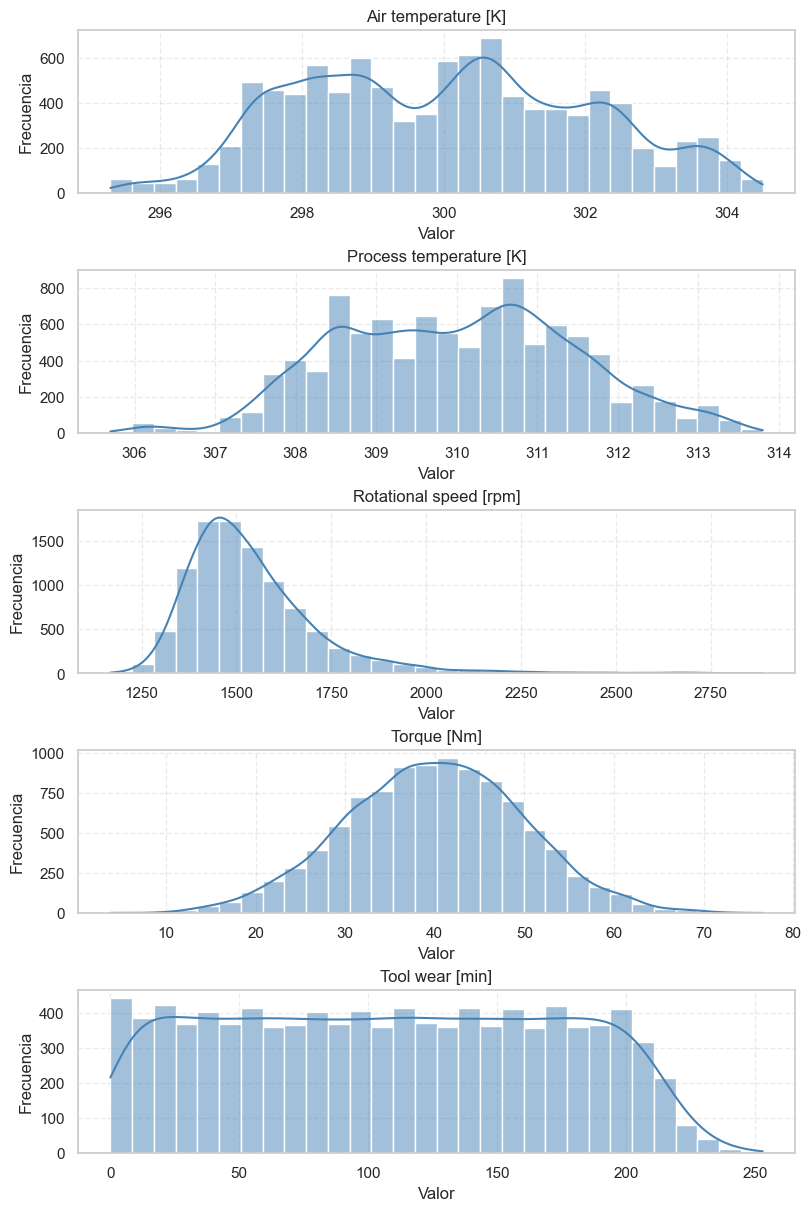

In [16]:
numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(8, 12), constrained_layout=True)
for ax, col in zip(axes, numeric_cols):
    sns.histplot(df[col], kde=True, bins=30, color='steelblue', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')
    ax.grid(True, linestyle='--', alpha=0.4)
plt.show()

* **Air & Process Temperature (Distribución Multimodal):**
    * No tienen una sola "joroba" (campana), sino varias.
    * **Lectura:** Esto sugiere que los datos se tomaron en **diferentes condiciones ambientales** (quizás turnos de día vs. noche, o verano vs. invierno).
    * **Pro Tip:** Ambas gráficas son casi idénticas en forma. Esto confirma que la temperatura del proceso está fuertemente correlacionada con la del aire.
* **Rotational Speed (Asimetría Positiva / Cola a la derecha):**
    * La mayoría de las operaciones ocurren entre **1400 y 1600 RPM**.
    * La "cola" larga hacia la derecha (hasta 2800) indica que hay momentos puntuales de **alta velocidad**. Esos puntos extremos suelen ser donde ocurren las vibraciones o roturas.
* **Torque (Distribución Normal / Campana de Gauss):**
    * Está perfectamente centrada en **40 Nm**.
    * **Lectura:** La máquina está diseñada para trabajar cómodamente en ese rango. Los valores en los extremos (cerca de 10 o de 70) son raros y probablemente peligrosos.
* **Tool wear (Distribución Uniforme):**
    * Es plana.
    * **Lectura:** Significa que el dataset contiene datos de herramientas en **todas las etapas de su vida**: recién puestas (0 min), a medio uso (100 min) y viejas (200 min).
    * Cae drásticamente a partir de **200-220 min** porque a partir de ahí las herramientas se rompen o se cambian. Ese es el **umbral de riesgo**.

## Mapas de calor y correlaciones

Heatmap de correlación entre variables numéricas y estados de fallo.

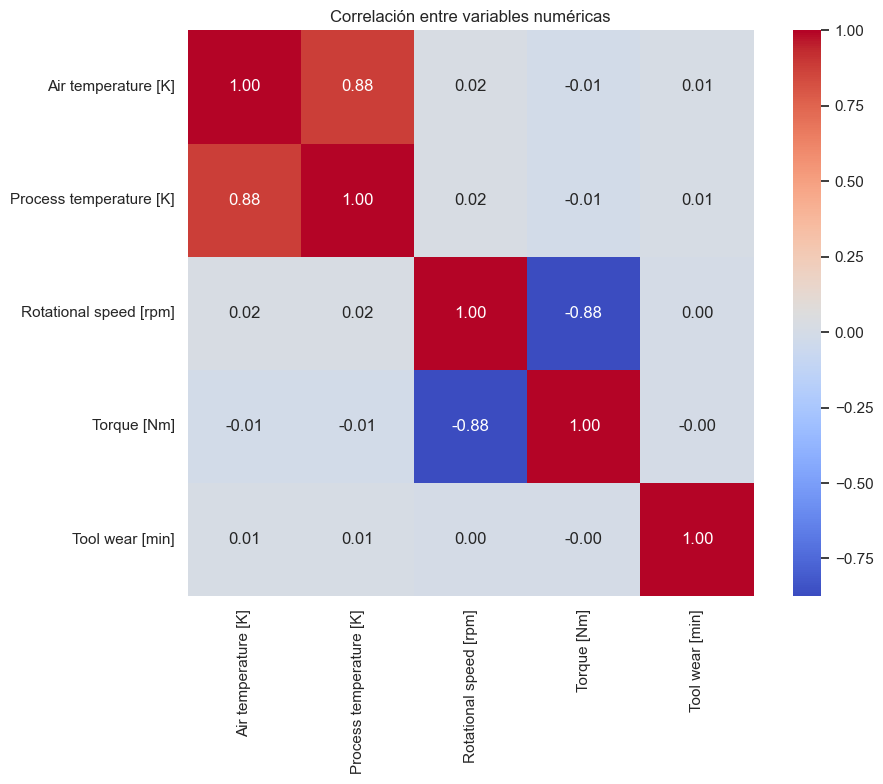

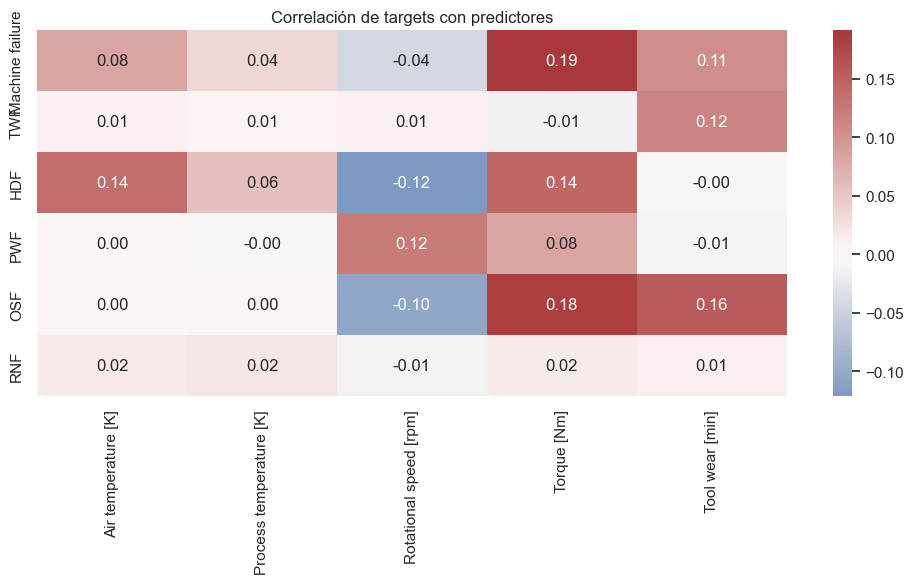

In [17]:
feature_corr = df[numeric_cols].corr()
target_cols = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
full_corr = df[numeric_cols + target_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(feature_corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlación entre variables numéricas')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(full_corr.loc[target_cols, numeric_cols], annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlación de targets con predictores')
plt.tight_layout()
plt.show()

### **GRÁFICO 1: Correlación entre variables numéricas**

* **El Cuadrado Rojo Superior (0.88):**
    * Hay una correlación casi perfecta entre `Air temperature` y `Process temperature`.
    * **Explicación:** Es termodinámica básica. Si hace calor en la fábrica (Air), la máquina se calienta más (Process). Se mueven juntas.
* **El Cuadrado Azul Central (-0.88):**
    * Hay una correlación inversa muy fuerte entre `Rotational speed` (RPM) y `Torque`.
    * **Explicación:** Esto es física pura ($Potencia \approx Torque \times Velocidad$). Si la máquina quiere mantener una potencia constante, cuando aumentas la velocidad, el torque baja obligatoriamente, y viceversa. **Esto valida que los datos son sintéticos de alta calidad basados en física real.**

---

### **GRÁFICO 2: Correlación de targets con predictores**

* **Machine Failure (Fallo General):** Sus mayores predictores son `Torque` (0.19) y `Tool wear` (0.11). O sea, la máquina falla principalmente por **fuerza excesiva** o **herramienta vieja**.
* **HDF (Fallo de Disipación de Calor):**
    * La fila HDF correlaciona con `Air temperature` (0.14) y `Process temperature`.
    * **Conclusión:** El calor mata la máquina.
* **OSF (Fallo por Sobrecarga/Overstrain):**
    * Correlación fuerte con `Torque` (0.18) y `Tool wear` (0.16).
    * **Conclusión:** Si aprietas mucho (Torque) con una herramienta gastada, rompes la máquina por esfuerzo.
* **PWF (Fallo de Potencia):**
    * Curiosamente correlaciona con `Rotational Speed` (0.12). Si vas muy rápido o muy lento fuera de la curva de potencia, fallas.
* **TWF (Fallo por Desgaste de Herramienta):**
    * Solo correlaciona con `Tool wear` (0.12).
    * **Dato Curioso:** Fíjate que `Torque` tiene correlación 0.19 con el fallo general, pero casi 0 con TWF. Esto te dice que el fallo de herramienta es "silencioso" hasta que ocurre, no depende tanto de la fuerza.

## Boxplots según tipo de fallo

Comparar distribuciones de valores clave por cada tipo de fallo para detectar outliers.

C:\Users\marco\AppData\Local\Temp\ipykernel_8716\4020405695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col].astype(str), y=df['Torque [Nm]'], palette='Set2', ax=ax)
C:\Users\marco\AppData\Local\Temp\ipykernel_8716\4020405695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col].astype(str), y=df['Torque [Nm]'], palette='Set2', ax=ax)
C:\Users\marco\AppData\Local\Temp\ipykernel_8716\4020405695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col].astype(str), y=df['Torque [Nm]'], palette='Set2', ax=ax)
C:\Users\m

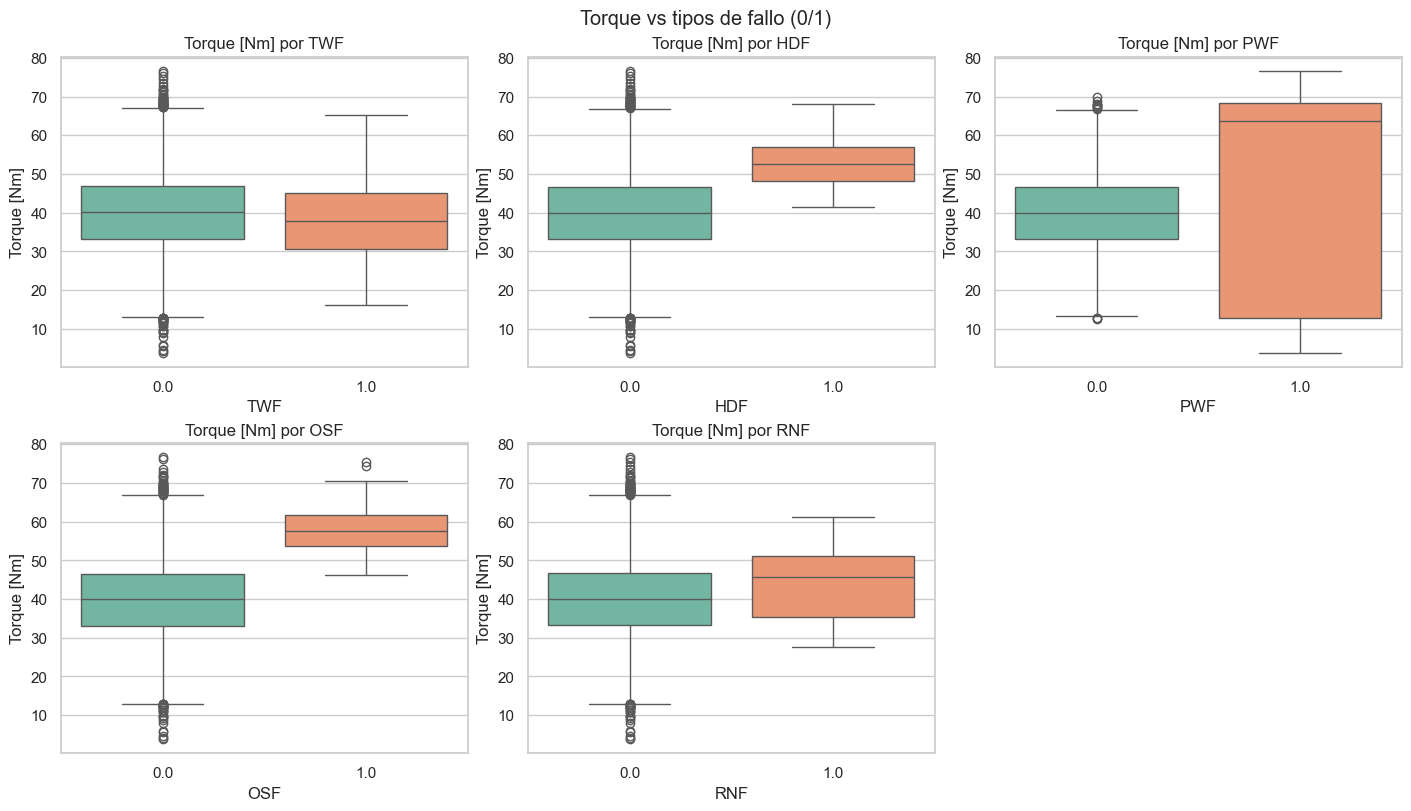

In [18]:
failure_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
axes = axes.flatten()
for ax, col in zip(axes, failure_cols):
    sns.boxplot(x=df[col].astype(str), y=df['Torque [Nm]'], palette='Set2', ax=ax)
    ax.set_title(f'Torque [Nm] por {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Torque [Nm]')
axes[-1].set_visible(False)
plt.suptitle('Torque vs tipos de fallo (0/1)')
plt.show()

1.  **Gráfico OSF:**
    * La caja naranja (Fallo=1) está clarísimamente más arriba que la verde.
    * **Conclusión:** Los fallos OSF ocurren casi exclusivamente cuando el Torque es alto (entre 50 y 60 Nm).
2.  **Gráfico PWF:**
    * La caja naranja es **gigante**.
    * **Conclusión:** Los fallos de potencia ocurren en todo el rango, pero especialmente cuando el Torque es muy alto o muy bajo (extremos). Es un fallo más caótico.
3.  **Gráfico TWF:**
    * Las cajas están casi a la misma altura.
    * **Conclusión:** El Torque **NO sirve** para predecir fallos de desgaste de herramienta (TWF). Hace falta mirar la variable `Tool wear` para eso.